# LSTM Model for predicting trend

In [61]:
#imports
import numpy as np
from math import sqrt
from numpy import concatenate

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

from matplotlib import pyplot
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

import keras.utils
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

import tensorflow as tf
import seaborn as sn
import seed
import os
tf.get_logger().setLevel('ERROR')

In [62]:
"""
method to create lagged features

data - data
to_keep - number of lagged_features
to_remove - number of days to remove

"""
def create_lagged_features(data, to_keep=1, to_remove=1):
    variables = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    columns, names = list(), list()
    
    for i in range(to_keep, 0, -1):
        columns.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(variables)]

    for i in range(0, to_remove):
        columns.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(variables)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(variables)]
            
    #put it all together
    final = concat(columns, axis=1)
    final.columns = names
    
    #drop rows with NaN values
    final.dropna(inplace=True)
        
    return final

In [63]:
"""
function to calculate rsi

data - data
period - RSI period

"""
def rsi(data, period: int = 14):
    
    delta = data["Close"].diff()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    gain = up.ewm(com=(period - 1), min_periods=period).mean()
    loss = down.abs().ewm(com=(period - 1), min_periods=period).mean()

    RS = gain / loss
    return 100 - (100 / (1 + RS))

In [64]:
#lag granularity - days or hours
lag_granularity = "days"
#lag value
lag = 1
# type of analyser - TextBlob or vader
analyser = "vader"
# analyser = "TextBlob"
#dataset grouped type - day or hour
dataset_grouped_by = "day"

In [65]:
#read dataset
folder = "./../datasets/tweets_prices_volumes_sentiment/"+analyser+"/"+dataset_grouped_by+"_datasets/"
filename = folder+"/final_data_lag_"+lag_granularity+"_"+str(lag)+".csv" if (lag > 0) else folder+"/final_data_no_lag.csv"
df = pd.read_csv(filename)

In [66]:
#group by datetime
df = df.groupby('DateTime').agg(lambda x: x.mean())

In [67]:
#get change label
df["Change"] = (df["Close"] > df["Close"].shift(1)).astype(int)

add_RSI = True
add_longMAvg = False
add_shortMAvg = False

if(add_RSI):
    #calcualte RSI
    RSI = 14
    df['RSI'] = rsi(df, RSI)
    df = df.iloc[RSI:]

#calculate moving averages
if(add_shortMAvg):
    short_window = 9
    df['short_mavg'] = df.rolling(window=short_window)["Close"].mean()
    
if(add_longMAvg):
    long_window = 21
    df["long_mavg"] = df.rolling(window=long_window)["Close"].mean()
    
if(add_longMAvg):
    df = df.iloc[long_window:]
elif(add_RSI):
    df = df.iloc[RSI:]
elif(add_shortMAvg):
    df = df.iloc[short_window:]

In [68]:
#keep only wanted columns
features = ['Change', 'subjectivity', 'polarity','Tweet_vol','Volume_(BTC)'] if analyser == "Textblob" else ['Change', 'Close', 'pos_pol', 'neg_pol', 'Tweet_vol']

if(add_RSI):
    features.append("RSI")
    
if(add_longMAvg):
    features.append("long_mavg")
    
if(add_shortMAvg):
    features.append("short_mavg")

df = df[features]

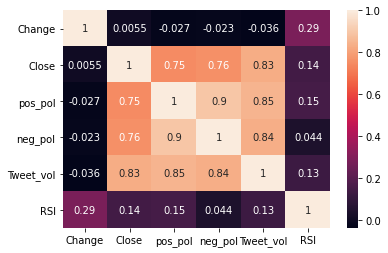

In [69]:
#plot correlation matrix
sn.heatmap(df.corr(), annot=True)
plt.show()

In [70]:
#creating copy so that data is not loaded once again
df_copy = df.copy()

In [71]:
print(features)

['Change', 'Close', 'pos_pol', 'neg_pol', 'Tweet_vol', 'RSI']


In [72]:
#number of previous records to consider for every example
n_lag = 1
#number of features
n_features = len(features)
#calculate total_features
total_features = n_lag*n_features

if(total_features == 0):
    total_features = n_features

In [73]:
#divide df into train and test
train_ratio = 0.85
data_len = len(df_copy)
train_size = int(data_len*train_ratio)


train = df_copy.iloc[:train_size]
test = df_copy.iloc[train_size:]

In [74]:
#prepare labels
train_y = train["Change"][n_lag:].values
test_y = test["Change"][n_lag:].values

train_y = train_y.reshape(len(train_y), 1)
test_y = test_y.reshape(len(test_y), 1)

In [75]:
#normalise features
xscaler = MinMaxScaler(feature_range=(0, 1))
train = xscaler.fit_transform(train)
test = xscaler.transform(test)

In [76]:
#add lagged data to records
train_with_lagged = create_lagged_features(train, n_lag, 1)
train_with_lagged = train_with_lagged.reset_index()
train_with_lagged = train_with_lagged.drop(['index'], axis=1)

test_with_lagged = create_lagged_features(test, n_lag, 1)
test_with_lagged = test_with_lagged.reset_index()
test_with_lagged = test_with_lagged.drop(['index'], axis=1)

In [77]:
#tprepare data
train = train_reframed.values
test = test_reframed.values
train_labels = train_y
test_labels = test_y

In [78]:
#remove the last set of values(data of time to be predicted)
train = train[:, :total_features]
test = test[:, :total_features]

In [79]:
#keep only prices array
train_X, train_y = train[:, :total_features], train_y[:, -1]
test_X, test_y = test[:, :total_features], test_y[:, -1]

In [80]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))

In [81]:
#set labels for training data to categorical
train_y = keras.utils.to_categorical(train_y, 2)

In [82]:
# np.random.seed(1)
# tf.random.set_seed(1)

# design network
model = Sequential()
neurons = 32
epochs = 1000
dropout = 0.25
batch_size = 5
activ_func = "linear"

model.add(LSTM(neurons, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), activation=activ_func))
model.add(Dropout(dropout))

model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
model.add(Dropout(dropout))
model.add(LSTM(neurons, return_sequences=False, activation=activ_func))
model.add(Dropout(dropout))

model.add(Dense(2, activation="softmax"))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False,validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 32)             4992      
_________________________________________________________________
dropout (Dropout)            (None, 1, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 32)             8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 6

Epoch 70/1000
58/58 - 0s - loss: 0.6793 - accuracy: 0.5839 - val_loss: 0.7122 - val_accuracy: 0.5417
Epoch 71/1000
58/58 - 0s - loss: 0.6620 - accuracy: 0.5769 - val_loss: 0.7141 - val_accuracy: 0.5694
Epoch 72/1000
58/58 - 0s - loss: 0.6702 - accuracy: 0.5734 - val_loss: 0.7156 - val_accuracy: 0.5556
Epoch 73/1000
58/58 - 0s - loss: 0.6763 - accuracy: 0.5734 - val_loss: 0.7168 - val_accuracy: 0.5694
Epoch 74/1000
58/58 - 0s - loss: 0.6818 - accuracy: 0.5664 - val_loss: 0.7150 - val_accuracy: 0.5694
Epoch 75/1000
58/58 - 0s - loss: 0.6713 - accuracy: 0.5979 - val_loss: 0.7177 - val_accuracy: 0.5556
Epoch 76/1000
58/58 - 0s - loss: 0.6739 - accuracy: 0.5734 - val_loss: 0.7117 - val_accuracy: 0.5694
Epoch 77/1000
58/58 - 0s - loss: 0.6732 - accuracy: 0.5874 - val_loss: 0.7130 - val_accuracy: 0.5417
Epoch 78/1000
58/58 - 0s - loss: 0.6745 - accuracy: 0.5804 - val_loss: 0.7127 - val_accuracy: 0.5694
Epoch 79/1000
58/58 - 0s - loss: 0.6738 - accuracy: 0.5909 - val_loss: 0.7151 - val_accurac

Epoch 151/1000
58/58 - 0s - loss: 0.6592 - accuracy: 0.6014 - val_loss: 0.7689 - val_accuracy: 0.5000
Epoch 152/1000
58/58 - 0s - loss: 0.6663 - accuracy: 0.5944 - val_loss: 0.7847 - val_accuracy: 0.5139
Epoch 153/1000
58/58 - 0s - loss: 0.6622 - accuracy: 0.6014 - val_loss: 0.7831 - val_accuracy: 0.5139
Epoch 154/1000
58/58 - 0s - loss: 0.6675 - accuracy: 0.5734 - val_loss: 0.7796 - val_accuracy: 0.5000
Epoch 155/1000
58/58 - 0s - loss: 0.6660 - accuracy: 0.5944 - val_loss: 0.7682 - val_accuracy: 0.5000
Epoch 156/1000
58/58 - 0s - loss: 0.6592 - accuracy: 0.5909 - val_loss: 0.7730 - val_accuracy: 0.5000
Epoch 157/1000
58/58 - 0s - loss: 0.6633 - accuracy: 0.6189 - val_loss: 0.7907 - val_accuracy: 0.5139
Epoch 158/1000
58/58 - 0s - loss: 0.6581 - accuracy: 0.5839 - val_loss: 0.7879 - val_accuracy: 0.5000
Epoch 159/1000
58/58 - 0s - loss: 0.6526 - accuracy: 0.6014 - val_loss: 0.7964 - val_accuracy: 0.5139
Epoch 160/1000
58/58 - 0s - loss: 0.6560 - accuracy: 0.6224 - val_loss: 0.7929 - v

Epoch 232/1000
58/58 - 0s - loss: 0.6536 - accuracy: 0.6154 - val_loss: 0.8493 - val_accuracy: 0.5139
Epoch 233/1000
58/58 - 0s - loss: 0.6495 - accuracy: 0.5769 - val_loss: 0.8579 - val_accuracy: 0.4861
Epoch 234/1000
58/58 - 0s - loss: 0.6501 - accuracy: 0.6084 - val_loss: 0.8528 - val_accuracy: 0.4861
Epoch 235/1000
58/58 - 0s - loss: 0.6537 - accuracy: 0.6189 - val_loss: 0.8431 - val_accuracy: 0.5000
Epoch 236/1000
58/58 - 0s - loss: 0.6569 - accuracy: 0.5944 - val_loss: 0.8044 - val_accuracy: 0.5139
Epoch 237/1000
58/58 - 0s - loss: 0.6529 - accuracy: 0.6224 - val_loss: 0.8264 - val_accuracy: 0.5139
Epoch 238/1000
58/58 - 0s - loss: 0.6574 - accuracy: 0.5944 - val_loss: 0.8365 - val_accuracy: 0.4861
Epoch 239/1000
58/58 - 0s - loss: 0.6537 - accuracy: 0.5944 - val_loss: 0.8458 - val_accuracy: 0.4861
Epoch 240/1000
58/58 - 0s - loss: 0.6487 - accuracy: 0.6084 - val_loss: 0.8502 - val_accuracy: 0.5000
Epoch 241/1000
58/58 - 0s - loss: 0.6470 - accuracy: 0.6189 - val_loss: 0.8253 - v

Epoch 313/1000
58/58 - 0s - loss: 0.6383 - accuracy: 0.5909 - val_loss: 0.9533 - val_accuracy: 0.4583
Epoch 314/1000
58/58 - 0s - loss: 0.6310 - accuracy: 0.6364 - val_loss: 0.9719 - val_accuracy: 0.5000
Epoch 315/1000
58/58 - 0s - loss: 0.6353 - accuracy: 0.6329 - val_loss: 0.9680 - val_accuracy: 0.5000
Epoch 316/1000
58/58 - 0s - loss: 0.6444 - accuracy: 0.6084 - val_loss: 0.9616 - val_accuracy: 0.4444
Epoch 317/1000
58/58 - 0s - loss: 0.6397 - accuracy: 0.6189 - val_loss: 0.9573 - val_accuracy: 0.5000
Epoch 318/1000
58/58 - 0s - loss: 0.6288 - accuracy: 0.6294 - val_loss: 0.9347 - val_accuracy: 0.5278
Epoch 319/1000
58/58 - 0s - loss: 0.6447 - accuracy: 0.6189 - val_loss: 0.9538 - val_accuracy: 0.5000
Epoch 320/1000
58/58 - 0s - loss: 0.6377 - accuracy: 0.6259 - val_loss: 0.9682 - val_accuracy: 0.4306
Epoch 321/1000
58/58 - 0s - loss: 0.6427 - accuracy: 0.6154 - val_loss: 0.9752 - val_accuracy: 0.5000
Epoch 322/1000
58/58 - 0s - loss: 0.6324 - accuracy: 0.6259 - val_loss: 0.9550 - v

Epoch 394/1000
58/58 - 0s - loss: 0.6397 - accuracy: 0.6224 - val_loss: 1.1837 - val_accuracy: 0.5000
Epoch 395/1000
58/58 - 0s - loss: 0.6390 - accuracy: 0.6434 - val_loss: 1.1611 - val_accuracy: 0.4722
Epoch 396/1000
58/58 - 0s - loss: 0.6464 - accuracy: 0.6119 - val_loss: 1.1459 - val_accuracy: 0.5000
Epoch 397/1000
58/58 - 0s - loss: 0.6447 - accuracy: 0.5979 - val_loss: 1.0968 - val_accuracy: 0.5000
Epoch 398/1000
58/58 - 0s - loss: 0.6414 - accuracy: 0.6154 - val_loss: 1.0998 - val_accuracy: 0.4861
Epoch 399/1000
58/58 - 0s - loss: 0.6410 - accuracy: 0.6154 - val_loss: 1.1013 - val_accuracy: 0.5000
Epoch 400/1000
58/58 - 0s - loss: 0.6343 - accuracy: 0.6154 - val_loss: 1.0850 - val_accuracy: 0.5000
Epoch 401/1000
58/58 - 0s - loss: 0.6258 - accuracy: 0.6154 - val_loss: 1.1746 - val_accuracy: 0.5000
Epoch 402/1000
58/58 - 0s - loss: 0.6412 - accuracy: 0.6224 - val_loss: 1.1397 - val_accuracy: 0.5000
Epoch 403/1000
58/58 - 0s - loss: 0.6385 - accuracy: 0.6259 - val_loss: 1.1706 - v

Epoch 475/1000
58/58 - 0s - loss: 0.6249 - accuracy: 0.6189 - val_loss: 1.3952 - val_accuracy: 0.5000
Epoch 476/1000
58/58 - 0s - loss: 0.6280 - accuracy: 0.6294 - val_loss: 1.4523 - val_accuracy: 0.5000
Epoch 477/1000
58/58 - 0s - loss: 0.6199 - accuracy: 0.6294 - val_loss: 1.4230 - val_accuracy: 0.5000
Epoch 478/1000
58/58 - 0s - loss: 0.6263 - accuracy: 0.6154 - val_loss: 1.4109 - val_accuracy: 0.5000
Epoch 479/1000
58/58 - 0s - loss: 0.6276 - accuracy: 0.6014 - val_loss: 1.4453 - val_accuracy: 0.5000
Epoch 480/1000
58/58 - 0s - loss: 0.6356 - accuracy: 0.6189 - val_loss: 1.3917 - val_accuracy: 0.5000
Epoch 481/1000
58/58 - 0s - loss: 0.6295 - accuracy: 0.6259 - val_loss: 1.3155 - val_accuracy: 0.5000
Epoch 482/1000
58/58 - 0s - loss: 0.6332 - accuracy: 0.6538 - val_loss: 1.3273 - val_accuracy: 0.5000
Epoch 483/1000
58/58 - 0s - loss: 0.6411 - accuracy: 0.6119 - val_loss: 1.2875 - val_accuracy: 0.5139
Epoch 484/1000
58/58 - 0s - loss: 0.6181 - accuracy: 0.6084 - val_loss: 1.3269 - v

Epoch 556/1000
58/58 - 0s - loss: 0.6205 - accuracy: 0.6189 - val_loss: 1.5605 - val_accuracy: 0.5000
Epoch 557/1000
58/58 - 0s - loss: 0.6141 - accuracy: 0.6434 - val_loss: 1.5454 - val_accuracy: 0.5139
Epoch 558/1000
58/58 - 0s - loss: 0.6266 - accuracy: 0.6224 - val_loss: 1.5685 - val_accuracy: 0.5139
Epoch 559/1000
58/58 - 0s - loss: 0.6206 - accuracy: 0.6329 - val_loss: 1.5742 - val_accuracy: 0.5139
Epoch 560/1000
58/58 - 0s - loss: 0.6154 - accuracy: 0.6434 - val_loss: 1.5620 - val_accuracy: 0.5000
Epoch 561/1000
58/58 - 0s - loss: 0.6130 - accuracy: 0.6469 - val_loss: 1.5833 - val_accuracy: 0.5000
Epoch 562/1000
58/58 - 0s - loss: 0.6220 - accuracy: 0.6224 - val_loss: 1.6095 - val_accuracy: 0.5000
Epoch 563/1000
58/58 - 0s - loss: 0.6138 - accuracy: 0.6119 - val_loss: 1.6423 - val_accuracy: 0.5000
Epoch 564/1000
58/58 - 0s - loss: 0.6027 - accuracy: 0.6748 - val_loss: 1.7373 - val_accuracy: 0.5000
Epoch 565/1000
58/58 - 0s - loss: 0.6181 - accuracy: 0.6329 - val_loss: 1.8193 - v

Epoch 637/1000
58/58 - 0s - loss: 0.6106 - accuracy: 0.6364 - val_loss: 2.0027 - val_accuracy: 0.5139
Epoch 638/1000
58/58 - 0s - loss: 0.6139 - accuracy: 0.6678 - val_loss: 1.9333 - val_accuracy: 0.5278
Epoch 639/1000
58/58 - 0s - loss: 0.6223 - accuracy: 0.6399 - val_loss: 1.8670 - val_accuracy: 0.5139
Epoch 640/1000
58/58 - 0s - loss: 0.5961 - accuracy: 0.6503 - val_loss: 2.0251 - val_accuracy: 0.5139
Epoch 641/1000
58/58 - 0s - loss: 0.6158 - accuracy: 0.6294 - val_loss: 2.0240 - val_accuracy: 0.5000
Epoch 642/1000
58/58 - 0s - loss: 0.6038 - accuracy: 0.6329 - val_loss: 1.9631 - val_accuracy: 0.5139
Epoch 643/1000
58/58 - 0s - loss: 0.6123 - accuracy: 0.6678 - val_loss: 2.0362 - val_accuracy: 0.5278
Epoch 644/1000
58/58 - 0s - loss: 0.6063 - accuracy: 0.6259 - val_loss: 1.9414 - val_accuracy: 0.5278
Epoch 645/1000
58/58 - 0s - loss: 0.6130 - accuracy: 0.6573 - val_loss: 1.8377 - val_accuracy: 0.5000
Epoch 646/1000
58/58 - 0s - loss: 0.6009 - accuracy: 0.6853 - val_loss: 1.9078 - v

Epoch 718/1000
58/58 - 0s - loss: 0.6079 - accuracy: 0.6294 - val_loss: 2.3461 - val_accuracy: 0.5139
Epoch 719/1000
58/58 - 0s - loss: 0.6004 - accuracy: 0.6678 - val_loss: 2.3191 - val_accuracy: 0.5139
Epoch 720/1000
58/58 - 0s - loss: 0.5947 - accuracy: 0.6678 - val_loss: 2.4479 - val_accuracy: 0.5139
Epoch 721/1000
58/58 - 0s - loss: 0.6072 - accuracy: 0.6503 - val_loss: 2.2901 - val_accuracy: 0.5139
Epoch 722/1000
58/58 - 0s - loss: 0.5948 - accuracy: 0.6329 - val_loss: 2.3437 - val_accuracy: 0.5139
Epoch 723/1000
58/58 - 0s - loss: 0.6023 - accuracy: 0.6503 - val_loss: 2.2615 - val_accuracy: 0.5139
Epoch 724/1000
58/58 - 0s - loss: 0.5999 - accuracy: 0.6224 - val_loss: 2.0834 - val_accuracy: 0.5139
Epoch 725/1000
58/58 - 0s - loss: 0.6025 - accuracy: 0.6573 - val_loss: 2.2057 - val_accuracy: 0.5278
Epoch 726/1000
58/58 - 0s - loss: 0.6058 - accuracy: 0.6224 - val_loss: 2.3097 - val_accuracy: 0.5278
Epoch 727/1000
58/58 - 0s - loss: 0.5911 - accuracy: 0.6748 - val_loss: 2.1570 - v

Epoch 799/1000
58/58 - 0s - loss: 0.6024 - accuracy: 0.6399 - val_loss: 1.8169 - val_accuracy: 0.5278
Epoch 800/1000
58/58 - 0s - loss: 0.5963 - accuracy: 0.6469 - val_loss: 1.8393 - val_accuracy: 0.5000
Epoch 801/1000
58/58 - 0s - loss: 0.5945 - accuracy: 0.6608 - val_loss: 1.9371 - val_accuracy: 0.5278
Epoch 802/1000
58/58 - 0s - loss: 0.6166 - accuracy: 0.6259 - val_loss: 1.8206 - val_accuracy: 0.5000
Epoch 803/1000
58/58 - 0s - loss: 0.6008 - accuracy: 0.6329 - val_loss: 1.7942 - val_accuracy: 0.5000
Epoch 804/1000
58/58 - 0s - loss: 0.5895 - accuracy: 0.6608 - val_loss: 1.9883 - val_accuracy: 0.5278
Epoch 805/1000
58/58 - 0s - loss: 0.6053 - accuracy: 0.6224 - val_loss: 2.0535 - val_accuracy: 0.5139
Epoch 806/1000
58/58 - 0s - loss: 0.6028 - accuracy: 0.6434 - val_loss: 1.9694 - val_accuracy: 0.5278
Epoch 807/1000
58/58 - 0s - loss: 0.5786 - accuracy: 0.6783 - val_loss: 2.0937 - val_accuracy: 0.5278
Epoch 808/1000
58/58 - 0s - loss: 0.5793 - accuracy: 0.6538 - val_loss: 2.2548 - v

Epoch 880/1000
58/58 - 0s - loss: 0.5854 - accuracy: 0.6294 - val_loss: 1.5483 - val_accuracy: 0.5278
Epoch 881/1000
58/58 - 0s - loss: 0.5951 - accuracy: 0.6748 - val_loss: 1.4297 - val_accuracy: 0.5417
Epoch 882/1000
58/58 - 0s - loss: 0.6008 - accuracy: 0.6469 - val_loss: 1.4150 - val_accuracy: 0.5278
Epoch 883/1000
58/58 - 0s - loss: 0.6020 - accuracy: 0.6364 - val_loss: 1.3616 - val_accuracy: 0.5278
Epoch 884/1000
58/58 - 0s - loss: 0.6010 - accuracy: 0.6573 - val_loss: 1.4573 - val_accuracy: 0.5278
Epoch 885/1000
58/58 - 0s - loss: 0.5921 - accuracy: 0.6434 - val_loss: 1.4135 - val_accuracy: 0.5278
Epoch 886/1000
58/58 - 0s - loss: 0.5794 - accuracy: 0.6608 - val_loss: 1.4771 - val_accuracy: 0.5139
Epoch 887/1000
58/58 - 0s - loss: 0.5879 - accuracy: 0.6818 - val_loss: 1.6126 - val_accuracy: 0.5139
Epoch 888/1000
58/58 - 0s - loss: 0.5805 - accuracy: 0.6888 - val_loss: 1.6871 - val_accuracy: 0.5278
Epoch 889/1000
58/58 - 0s - loss: 0.5904 - accuracy: 0.6783 - val_loss: 1.6327 - v

Epoch 961/1000
58/58 - 0s - loss: 0.5748 - accuracy: 0.6469 - val_loss: 1.5307 - val_accuracy: 0.5278
Epoch 962/1000
58/58 - 0s - loss: 0.5890 - accuracy: 0.6783 - val_loss: 1.5066 - val_accuracy: 0.5278
Epoch 963/1000
58/58 - 0s - loss: 0.5625 - accuracy: 0.6573 - val_loss: 1.5291 - val_accuracy: 0.5278
Epoch 964/1000
58/58 - 0s - loss: 0.5742 - accuracy: 0.6818 - val_loss: 1.5530 - val_accuracy: 0.5278
Epoch 965/1000
58/58 - 0s - loss: 0.5715 - accuracy: 0.6643 - val_loss: 1.5758 - val_accuracy: 0.5278
Epoch 966/1000
58/58 - 0s - loss: 0.5899 - accuracy: 0.6608 - val_loss: 1.6265 - val_accuracy: 0.5278
Epoch 967/1000
58/58 - 0s - loss: 0.5650 - accuracy: 0.6783 - val_loss: 1.5557 - val_accuracy: 0.5278
Epoch 968/1000
58/58 - 0s - loss: 0.5831 - accuracy: 0.6573 - val_loss: 1.5630 - val_accuracy: 0.5278
Epoch 969/1000
58/58 - 0s - loss: 0.5945 - accuracy: 0.6538 - val_loss: 1.4919 - val_accuracy: 0.5278
Epoch 970/1000
58/58 - 0s - loss: 0.5720 - accuracy: 0.6748 - val_loss: 1.4839 - v

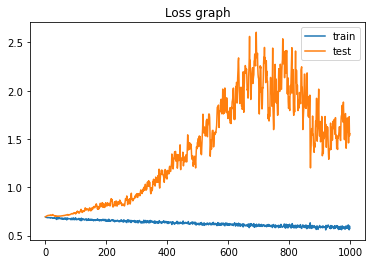

In [83]:
#plot loss graph
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Loss graph")
plt.show()

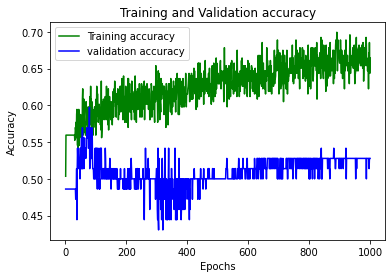

In [84]:
#plot training and validation accuracy
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,epochs + 1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [85]:
#reshape
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))

#predict values for test data
pred = model.predict(test_X)

#reshape again
test_X = test_X.reshape((test_X.shape[0], n_lag* n_features,))

In [86]:
#change back from categorical
pred = np.argmax(pred, axis=1)

In [87]:
#calculate accuracy
prices = pd.DataFrame()
prices["Actual"] = test_y
prices["Predicted"] = pred

prices["Correct"] = (prices["Actual"] - prices["Predicted"]) == 0
incorrect = prices.loc[prices['Correct'] == False]
incorrect_len = len(incorrect)
prices_len = len(prices)

print("Accuracy = ",((prices_len-incorrect_len)/prices_len))

Accuracy =  0.4126984126984127
